**In this section, we will show the consistency of different SV methods.**

# Load data

<https://www.kaggle.com/c/bike-sharing-demand>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import sage

In [2]:
# Load data
df = sage.datasets.bike()
feature_names = df.columns.tolist()[:-3]

In [3]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123
)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123
)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

# Train model

In [4]:
import xgboost as xgb

In [5]:
# Set up data
dtrain = xgb.DMatrix(train, label=Y_train)
dval = xgb.DMatrix(val, label=Y_val)

# Parameters
param = {"max_depth": 10, "objective": "reg:squarederror", "nthread": 4}
evallist = [(dtrain, "train"), (dval, "val")]
num_round = 50

# Train
model = xgb.train(param, dtrain, num_round, evals=evallist, verbose_eval=False)

In [6]:
# Calculate performance
mean = np.mean(Y_train)
base_mse = np.mean((mean - Y_test) ** 2)
mse = np.mean((model.predict(xgb.DMatrix(test)) - Y_test) ** 2)

print("Base rate MSE = {:.2f}".format(base_mse))
print("Model MSE = {:.2f}".format(mse))

Base rate MSE = 31591.23
Model MSE = 2011.59


# SAGE methods

In [7]:
# Set up imputer
imputer = sage.MarginalImputer(model, test[:512])

# Set up estimators
permutation_estimator = sage.PermutationEstimator(imputer, "mse")
kernel_estimator = sage.KernelEstimator(imputer, "mse")

In [8]:
explanation1 = permutation_estimator(test, Y_test, thresh=0.02)
explanation2 = kernel_estimator(test, Y_test, thresh=0.02)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

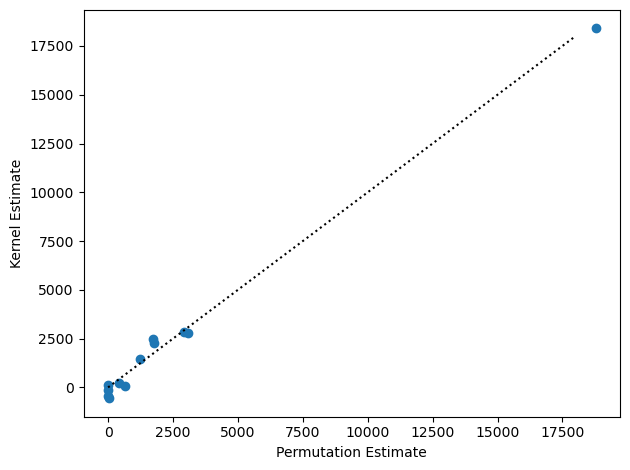

In [9]:
plt.figure()

plt.scatter(explanation1.values, explanation2.values)
plt.plot([0, 18000], [0, 18000], linestyle=":", color="black")
plt.xlabel('Permutation Estimate')
plt.ylabel('Kernel Estimate')
plt.tight_layout()
plt.show()

# SIT-KSHAP

In [11]:
from sklearn.metrics import mean_squared_error
from sit_kshap import imputers, estimator

In [12]:
sit_imputer = imputers.MarginalImputer(model, train[:512], sample_num=10)
sit_estimator = estimator.SIT_KSHAP(train[:512], sit_imputer, mean_squared_error, l2_penalty=0.01, t=0.5)

In [13]:
sit_value1= sit_estimator(test, Y_test, 120, 512, thresh=0.02)
sit_value2= sit_estimator(test, Y_test, 120, 512, thresh=0.02, avoid_negative=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.01954057361855467.


  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.01967143329891557.


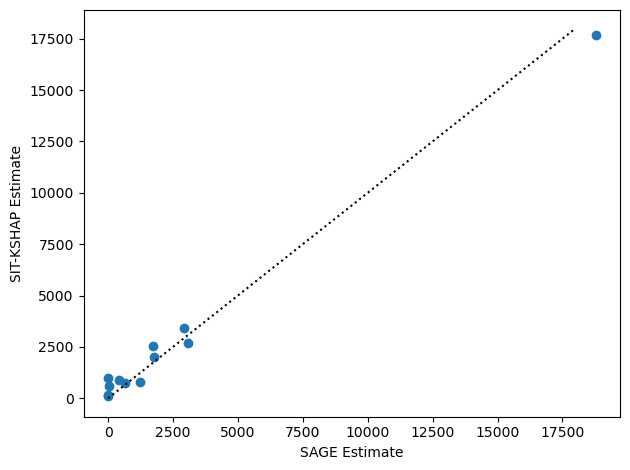

In [19]:
plt.figure()
plt.scatter(explanation1.values, sit_value1)
plt.plot([0, 18000], [0, 18000], linestyle=":", color="black")
plt.xlabel('SAGE Estimate')
plt.ylabel('SIT-KSHAP Estimate')
plt.tight_layout()
plt.show()

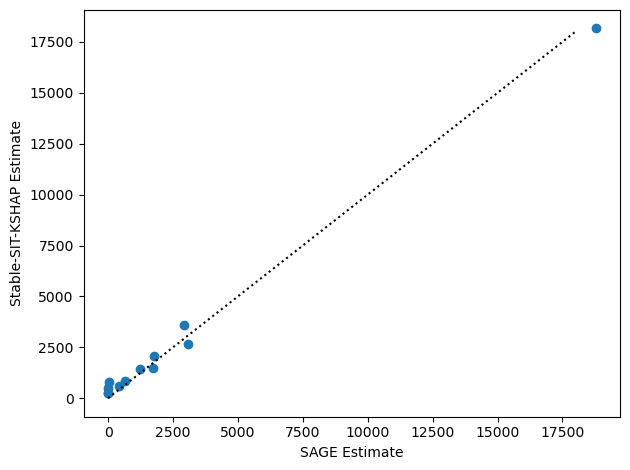

In [20]:
plt.figure()
plt.scatter(explanation1.values, sit_value2)
plt.plot([0, 18000], [0, 18000], linestyle=":", color="black")
plt.xlabel('SAGE Estimate')
plt.ylabel('Stable-SIT-KSHAP Estimate')
plt.tight_layout()
plt.show()

In [16]:
import scipy.stats as st

In [17]:
st.pearsonr(explanation1.values, sit_value1)[0]

0.9964603457992438

In [18]:
st.pearsonr(explanation1.values, sit_value2)[0]

0.9980546596991922